### [Kaggle Toxic Comment Classification](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

* Identify and classify toxic online comments
* Ref: [https://towardsdatascience.com/use-torchtext-to-load-nlp-datasets-part-i-5da6f1c89d84](https://towardsdatascience.com/use-torchtext-to-load-nlp-datasets-part-i-5da6f1c89d84)
* Ref: [https://zhuanlan.zhihu.com/p/34722385](https://zhuanlan.zhihu.com/p/34722385)
* Ref: [https://www.jianshu.com/p/e5adb235399e](https://www.jianshu.com/p/e5adb235399e)
* Ref: [http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/](http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/)
* Ref: [http://anie.me/On-Torchtext/](http://anie.me/On-Torchtext/)

In [1]:
import random, re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import spacy
from torchtext import data
from torchtext.vocab import GloVe

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

%matplotlib inline

# Create Dataset and Dataloader

In [2]:
# define custom tokenizer
# ref: https://towardsdatascience.com/use-torchtext-to-load-nlp-datasets-part-i-5da6f1c89d84
# ref: https://zhuanlan.zhihu.com/p/34722385
NLP = spacy.load('en')

def tokenizer(comment):
    comment = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;.#$%&;@%!,?]", " ", str(comment))
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\!+", " ", comment)
    comment = re.sub(r"\,+", " ", comment)
    comment = re.sub(r"\?+", " ", comment)
    
    tokens = [x.text for x in NLP.tokenizer(comment) if x.text != " "]
    
    return tokens

In [3]:
# define data fields
TEXT = data.Field(sequential=True, lower=True, tokenize=tokenizer, batch_first=True, 
                  pad_first=True, is_target=False)

LABELS = data.Field(sequential=False, use_vocab=False, batch_first=True, is_target=True)

In [4]:
# create dataset
fields = [('id', None), ('comment_text', TEXT), ('toxic', LABELS), ('severe_toxic', LABELS), 
          ('obscene', LABELS), ('threat', LABELS), ('insult', LABELS), ('identity_hate', LABELS)] 

train = data.TabularDataset(path='./data/toxic-comment/train.csv', format='CSV', fields=fields, skip_header=True)

train, val = train.split(split_ratio=0.8)

test = data.TabularDataset(path='./data/toxic-comment/test.csv', format='CSV', fields=fields, skip_header=True)

In [5]:
# build Vocab
TEXT.build_vocab(train, val, test, vectors=GloVe(name='6B', dim=100))

In [6]:
# build iterator
train_iter, val_iter = data.BucketIterator.splits((train, val), batch_sizes=(64, 64), repeat=False, 
                                                  sort_key=lambda x: len(x.comment_text), 
                                                  shuffle=True, sort_within_batch=False)

test_iter = data.Iterator(test, batch_size=1, train=False, repeat=False, shuffle=False, sort=False)

In [7]:
# build custom iterator wrapper
class BatchWrapper(object):
    def __init__(self, data_iter, x_var, y_vars):
        self.data_iter = data_iter
        self.x_var = x_var
        self.y_vars = y_vars
        
    def __iter__(self):
        for batch in self.data_iter:
            x = getattr(batch, self.x_var)
            y_list = [getattr(batch, y_var).unsqueeze(1) for y_var in self.y_vars]
            y = torch.cat(y_list, dim=1).float()
            
            yield (x, y)
            
    def __len__(self):
        return len(self.data_iter)
    
# wrap iterators
x_var = 'comment_text'
y_vars = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train_loader = BatchWrapper(train_iter, x_var, y_vars)
val_loader = BatchWrapper(val_iter, x_var, y_vars)
test_loader = BatchWrapper(test_iter, x_var, y_vars)

# Define LSTM Model

In [8]:
# define LSTM model
class MyLSTM(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, num_layers=1, dropout=0):
        super(MyLSTM, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, 
                            dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 6)
        
    def forward(self, x):
        embeds = self.embedding(x)
        output, _ = self.lstm(embeds)
        batch, seq_len, _ = output.shape
        output = output.reshape(batch, seq_len, 2, -1)
        
        forward_output = output[:, -1, 0, :].view(batch, -1)
        backward_output = output[:, 0, 1, :].view(batch, -1)
        concat = torch.cat([forward_output, backward_output], dim=1)
        
        prediction = self.fc(concat)
        
        return prediction

# Build Model

In [9]:
# vector size
vectors = TEXT.vocab.vectors
vectors.shape

torch.Size([276872, 100])

In [10]:
# define 1 layer LSTM
model = MyLSTM(num_embeddings=len(vectors), embedding_dim=100, hidden_size=50, num_layers=1, dropout=0)

model

MyLSTM(
  (embedding): Embedding(276872, 100)
  (lstm): LSTM(100, 50, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=6, bias=True)
)

In [11]:
# use pretrained embedding
model.embedding.weight.data = vectors
model.embedding.weight.requires_grad = False

In [12]:
# define loss and optimizer
criterion = nn.BCEWithLogitsLoss(reduction='mean')

params = [param for param in model.parameters() if param.requires_grad is True]
optimizer = optim.Adam(params=params, lr=0.001)

In [13]:
# train neural network
num_epochs = 10
train_loss_list = []
val_loss_list = []

# keep recording the best model
best_epoch = None
train_best_loss = float('inf')
val_best_loss = float('inf')

for i in range(num_epochs):
    t0 = time.time()
    train_loss = 0
    train_cnt = 0
    
    # training steps
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * len(batch_x)
        train_cnt += len(batch_x)
        
    # validation steps
    val_loss = 0
    val_cnt = 0
    
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            output = model(batch_x)
            loss = criterion(output, batch_y)
            
            val_loss += loss.item() * len(batch_x)
            val_cnt += len(batch_x)
       
    # help information
    train_epoch_loss = train_loss / train_cnt
    val_epoch_loss = val_loss / val_cnt
    
    train_loss_list.append(train_epoch_loss)
    val_loss_list.append(val_epoch_loss)
    
    elapsed_time = time.time() - t0
    string_prefix = 'Epoch {:3} ===>  train_loss:{:8.5f}  val_loss:{:8.5f}  time:{:5.0f}s'
    print(string_prefix.format(i + 1, train_epoch_loss, val_epoch_loss, elapsed_time))
    
    # keep recording the best model
    if val_epoch_loss < val_best_loss:
        torch.save(model.state_dict(), './model/toxic_model.pt')
        best_epoch = i + 1
        train_best_loss = train_epoch_loss
        val_best_loss = val_epoch_loss

# get the best model information
print('-' * 80)
print('Best Model')
string_prefix = 'Epoch {:3} ===>  train_loss:{:8.5f}  val_loss:{:8.5f}'
print(string_prefix.format(best_epoch, train_best_loss, val_best_loss))
print('-' * 80)

Epoch   1 ===>  train_loss: 0.08213  val_loss: 0.07602  time: 1964s
Epoch   2 ===>  train_loss: 0.05583  val_loss: 0.07192  time: 1885s
Epoch   3 ===>  train_loss: 0.05260  val_loss: 0.06983  time: 1758s
Epoch   4 ===>  train_loss: 0.04880  val_loss: 0.05600  time: 1779s
Epoch   5 ===>  train_loss: 0.04609  val_loss: 0.05565  time: 1802s
Epoch   6 ===>  train_loss: 0.04420  val_loss: 0.05739  time: 1657s
Epoch   7 ===>  train_loss: 0.04231  val_loss: 0.05504  time: 2357s
Epoch   8 ===>  train_loss: 0.04074  val_loss: 0.05310  time: 2270s
Epoch   9 ===>  train_loss: 0.03935  val_loss: 0.05318  time: 2396s
Epoch  10 ===>  train_loss: 0.03849  val_loss: 0.05089  time: 2295s
--------------------------------------------------------------------------------
Best Model
Epoch  10 ===>  train_loss: 0.03849  val_loss: 0.05089
--------------------------------------------------------------------------------


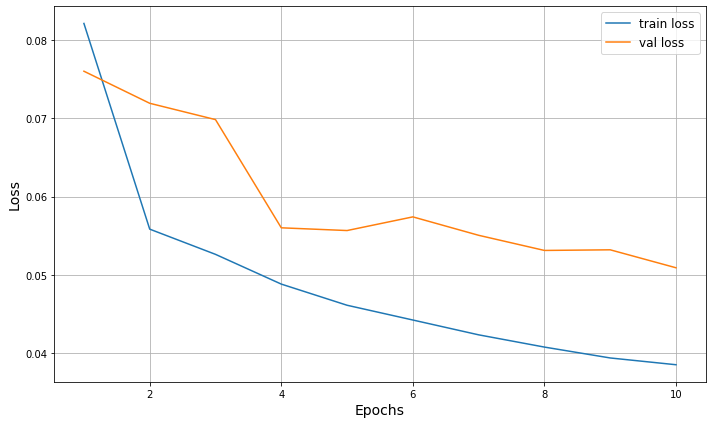

In [14]:
# visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='train loss')
ax.plot(range(1, len(val_loss_list) + 1), val_loss_list, label='val loss')
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

# Make Prediction

In [15]:
# load model
model.load_state_dict(torch.load('./model/toxic_model.pt'))
model.eval()

MyLSTM(
  (embedding): Embedding(276872, 100)
  (lstm): LSTM(100, 50, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=6, bias=True)
)

In [25]:
# make predictions
test_label = []
test_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        # corner case: no sentence
        if batch_x.shape[1] == 0:
            test_pred.append(np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))
            test_label.append(batch_y.squeeze().numpy())
            continue
            
        output = model(batch_x)
        prediction = torch.sigmoid(output).squeeze().numpy()
        
        test_pred.append(prediction)
        test_label.append(batch_y.squeeze().numpy())
            
test_pred = np.array(test_pred)
test_label = np.array(test_label, dtype=int)

In [41]:
# calculate AUC
names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
fpr_list = []
tpr_list = []
auc_list = []

for i in range(6):
    y_true = test_label[:, i]
    y_score = test_pred[:, i]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)

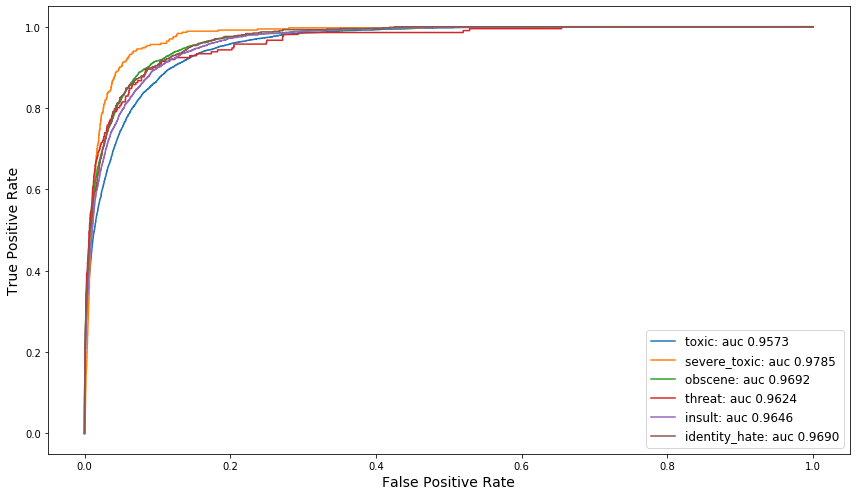

In [58]:
# visualization
fig, ax = plt.subplots(figsize=(12, 7))
for i in range(6):
    fpr, tpr, auc = fpr_list[i], tpr_list[i], auc_list[i]
    ax.plot(fpr, tpr, label='{}: auc {:5.4f}'.format(names[i], auc))
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()